<div class="alert alert-block alert-info">
<b>Deadline:</b> March 22, 2023 (Wednesday) 23:00
</div>

# Exercise 2. Recommender system

In this exercise, your task is to design a recommender system.

## Learning goals:
* Practise tuning a neural network model by using different regularization methods.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.decomposition import PCA

import data

In [26]:
df_movies = pd.read_csv('movies.csv')
df_links = pd.read_csv('links.csv')[['movieId', 'tmdbId', 'imdbId']]
df_movies = df_movies.merge(df_links, how='left', on='movieId')
df_movies = pd.concat([df_movies, df_movies.genres.str.get_dummies('|')], axis=1)
df_movies = df_movies.drop(columns=['(no genres listed)', 'genres'])

sorted_unique_ids = sorted(df_movies['movieId'].unique())

# Step 2: Create a mapping of IDs to indices based on the sorted order
id_to_index_mapping = {id: idx for idx, id in enumerate(sorted_unique_ids)}

# Step 3: Replace values in column A with the corresponding indices
df_movies['movieId'] = df_movies['movieId'].map(id_to_index_mapping)

df_movies

,movieId,title,tmdbId,imdbId,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,Toy Story (1995),862.0,114709,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Jumanji (1995),8844.0,113497,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,Grumpier Old Men (1995),15602.0,113228,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,3,Waiting to Exhale (1995),31357.0,114885,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,4,Father of the Bride Part II (1995),11862.0,113041,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,9737,Black Butler: Book of the Atlantic (2017),432131.0,5476944,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9738,9738,No Game No Life: Zero (2017),445030.0,5914996,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9739,9739,Flint (2017),479308.0,6397426,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,9740,Bungo Stray Dogs: Dead Apple (2018),483455.0,8391976,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
from tqdm.auto import tqdm

In [ ]:
from tmdbv3api import TMDb
from tmdbv3api import Movie
tmdb=TMDb()
#set you unique API key that you get from TMDB after registartion in my case this is my API key
TMDb.api_key='eb694832e717f6712c1cbe5c7ec09f92'
#you can also export your api key as environment variable using this below export command
# export TMDb_API_KEY='6f15568d9aa3d15d0261a5454578c28b'
#it's optional it's for setting language of Data that we'll fetch from TMDB
tmdb.language = 'en'
#for debugging we have set it true 
tmdb.debug = True
movie=Movie()
#here I have fetched movie data using movie_id 
similar = movie.similar(343611)
#iterate through the data since it have multiple information
for s in similar:
    #print required data like in my case title of movie and it's overview, poster path
    print("Title of the movie: ", s.title)
    print("Overview of the movie:", s.overview)
    print("Poster of the Movie:", s.poster_path)

In [ ]:
for a, b in movie.details(tmdb_id).items():
    print(a,b)

In [5]:

movie_info = []
for tmdb_id in tqdm(df_movies.tmdbId):
    try:
        movie_detail = movie.details(tmdb_id)
        movie_info.append([movie_detail['vote_average'], 
                           movie_detail['overview'], 
                           movie_detail['popularity']])
    except:
        movie_info.append([])

  0%|          | 0/9742 [00:00<?, ?it/s]

In [ ]:
movie_info

In [124]:
import pickle

with open('movie_info.pickle', 'wb') as handle:
    pickle.dump(movie_info, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [4]:
import pickle

with open('movie_info.pickle', 'rb') as handle:
    movie_info = pickle.load(handle)


In [5]:
from sentence_transformers import SentenceTransformer
deep_embedder = SentenceTransformer('all-MiniLM-L6-v2')


In [6]:
movie_scores = []
movie_plot = []
movie_popularity = []

for movie_detail in tqdm(movie_info):
    try:
        movie_scores.append(movie_detail[0])
        movie_plot.append(deep_embedder.encode(movie_detail[1]))
        movie_popularity.append(movie_detail[2])
    except:
        movie_scores.append(0)
        movie_plot.append(np.zeros(384))
        movie_popularity.append(0)


  0%|          | 0/9742 [00:00<?, ?it/s]

In [27]:
df_movies['ratings'] = movie_scores
df_movies['popularity'] = movie_popularity

df_movies

,movieId,title,tmdbId,imdbId,Action,Adventure,Animation,Children,Comedy,Crime,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,ratings,popularity
0,0,Toy Story (1995),862.0,114709,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,7.970,118.406
1,1,Jumanji (1995),8844.0,113497,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,7.239,18.160
2,2,Grumpier Old Men (1995),15602.0,113228,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,6.493,9.367
3,3,Waiting to Exhale (1995),31357.0,114885,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,6.183,8.736
4,4,Father of the Bride Part II (1995),11862.0,113041,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,6.235,15.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,9737,Black Butler: Book of the Atlantic (2017),432131.0,5476944,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,7.667,10.012
9738,9738,No Game No Life: Zero (2017),445030.0,5914996,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,7.831,17.053
9739,9739,Flint (2017),479308.0,6397426,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6.800,3.401
9740,9740,Bungo Stray Dogs: Dead Apple (2018),483455.0,8391976,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,8.240,16.274


In [47]:
skip_training = False  # Set this flag to True before validation and submission

In [71]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [72]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## Ratings dataset

We will train the recommender system on the dataset in which element consists of three values:
* `user_id` - id of the user (the smallest user id is 1)
* `item_id` - id of the movie (the smallest item id is 1)
* `rating` - rating given by the user to the item (ratings are integer numbers between 1 and 5.

The recommender system need to predict the rating for any given pair of `user_id` and `item_id`.

We measure the quality of the predicted ratings using the mean-squared error (MSE) loss:
$$
  \frac{1}{N}\sum_{i=1}^N (r_i - \hat{r}_i)^2
$$
where $r_i$ is a real rating and $\hat{r}_i$ is a predicted one.

Note: The predicted rating $\hat{r}_i$ does not have to be an integer number.

In [73]:
trainset = data.RatingsData(root=None, train=True)
testset = data.RatingsData(root=None, train=False)

In [74]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)

In [75]:
# Print one sample from the dataset
x = trainset[5]
print(f'user_id={x[0]}, item_id={x[1]}, rating={x[2]}')

user_id=599, item_id=1548, rating=3.5


In [250]:
class RecommenderSystem(nn.Module):
    
    def __init__(self, n_users, n_items
                ):
        """
        Args:
          n_users: Number of users.
          n_items: Number of items.
        """
        super(RecommenderSystem, self).__init__()
        self.embedding_user = nn.Embedding(n_users+1,10)
        self.embedding_item = nn.Embedding(n_items+1,10)
        self.layer_item = self.layers = nn.Sequential(
                    nn.Linear(36, 60),
                    nn.Tanh(),
                    nn.Dropout(0.3),
                    nn.Linear(60, 10)
                    )
        
        self.layers = nn.Sequential(
                    nn.Linear(20, 40),
                    nn.Tanh(),
                    nn.Dropout(0.3),
                    nn.Linear(40, 10),
                    nn.Tanh(),
                    nn.Dropout(0.2),
                    nn.Linear(10,1)
                    )
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(384, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 5)
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(5, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 384),
            torch.nn.Sigmoid()
        )
        
    def forward(self, user_ids, item_ids, item_feature, plot_feature):
        """
        Args:
          user_ids of shape (batch_size): User ids (starting from 1).
          item_ids of shape (batch_size): Item ids (starting from 1).
        
        Returns:
          outputs of shape (batch_size): Predictions of ratings.
        """
        emb_user = self.embedding_user(user_ids)
        emb_item = self.embedding_item(item_ids)
        emb_plot = self.encoder(plot_feature)
        reconsruct_plot = self.decoder(emb_plot)
        fea_item = self.layer_item(torch.concat([item_feature, emb_item, emb_plot],1))
        emb_concat = torch.concat([emb_user, fea_item],1)
        return self.layers(emb_concat).flatten(), reconsruct_plot

## Train the model

You need to train a recommender system using **only the training data.** Please use the test set to select the best model: the model that generalizes best to out-of-training data.

**IMPORTANT**:
* During testing, the predictions are produced by `predictions = model(user_ids, item_ids)` with the `user_ids` and `item_ids` loaded from `RatingsData`.
* There is a size limit of 30Mb for saved models.

In [251]:

pca = PCA(n_components=15)
movie_plot_arr = np.stack(movie_plot).astype('float32')
#movie_plot_arr_compact = pca.fit_transform(movie_plot_arr)
#movie_plot_arr_compact.shape

In [252]:
movie_features= df_movies.drop(columns=['movieId', 'title', 'tmdbId', 'imdbId']).to_numpy().astype('float32')
with torch.no_grad():
    item_features = torch.tensor(np.hstack([movie_features]))
    item_features
    plot_tensor = torch.tensor(movie_plot_arr)
item_features.shape

torch.Size([9742, 21])

In [253]:
# Create the model
# IMPORTANT: the default value of the architecture argment should define your best model.
model = RecommenderSystem(610, 9742)
model.to(device)

RecommenderSystem(
  (embedding_user): Embedding(611, 10)
  (embedding_item): Embedding(9743, 10)
  (layer_item): Sequential(
    (0): Linear(in_features=36, out_features=60, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=60, out_features=10, bias=True)
  )
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=40, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=40, out_features=10, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
  (encoder): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=36, bias=True)
    (5): ReLU()
    (6): Linear(in_features=36, out_features=18, bias=True)
    (7): ReLU()
    (8): Linear(in_features=18, out_features=5

In [254]:
def get_mse(a, crit, loader):
    mse_total = 0
    iters = 0
    a.eval()
    with torch.no_grad():
        for ser_ids, item_ids, rating in loader:
            item_fea = item_features[item_ids]
            plot_emb = plot_tensor[item_ids] 
            prediction, _ = a(ser_ids, item_ids, item_fea, plot_emb)
            mse_total += crit(prediction, rating).item()
            iters+= 1
    return mse_total/iters

In [270]:
optim = torch.optim.Adam(model.parameters(), lr=0.0005,  weight_decay=0.001)
criterion = nn.MSELoss()
for i in range(20):
    model.train()
    for ser_ids, item_ids, rating in trainloader:
        optim.zero_grad()
        item_fea = item_features[item_ids]
        plot_emb = plot_tensor[item_ids] 
        prediction, reconst_plot = model(ser_ids, item_ids, item_fea,plot_emb)
        loss = criterion(prediction, rating) + 0.1 * criterion(reconst_plot,plot_emb)
        loss.backward()
        optim.step()
    print("Epoch", i)
    print("Training", get_mse(model,criterion, trainloader), "Test", get_mse(model,criterion, testloader))
    

Epoch 0
Training 0.6878723770037193 Test 0.6981043138325854
Epoch 1
Training 0.679138984940488 Test 0.6898600300551452
Epoch 2
Training 0.6986002843385176 Test 0.7061528750583939
Epoch 3
Training 0.6668609997456342 Test 0.6763722034183866
Epoch 4
Training 0.6667267971985021 Test 0.6770975705800393
Epoch 5
Training 0.6605911270369145 Test 0.6706284073646592
Epoch 6
Training 0.6595752765171493 Test 0.669588867468429
Epoch 7
Training 0.6631107592644175 Test 0.673655588918235
Epoch 8
Training 0.6593287303742318 Test 0.669826997021146
Epoch 9
Training 0.6582290817174775 Test 0.6678334760592018
Epoch 10
Training 0.6935465541778695 Test 0.7006471952126981
Epoch 11
Training 0.6538849111435102 Test 0.6645872457090255


KeyboardInterrupt: 

In [257]:
test_set = pd.read_csv('test_set_no_ratings.csv')
test_set['movieId'] = test_set['movieId'].map(id_to_index_mapping)
sorted_unique_users = sorted(pd.read_csv('train_ratings.csv')['userId'].unique())

userid_to_index_mapping = {id: idx for idx, id in enumerate(sorted_unique_users)}
test_set['userId'] = test_set['userId'].map(userid_to_index_mapping)
test_set

,Id,userId,movieId
0,0,431,7333
1,1,287,412
2,2,598,3222
3,3,41,2250
4,4,74,1211
...,...,...,...
20163,20163,379,3666
20164,20164,433,6530
20165,20165,225,4159
20166,20166,606,1009


In [276]:
model.eval()
test_users = torch.LongTensor(test_set.userId.to_numpy())
test_items = torch.LongTensor(test_set.movieId.to_numpy())
prediction, _ = model(test_users,test_items, item_features[test_items], plot_tensor[test_items] )
prediction

tensor([2.7416, 3.4041, 2.5351,  ..., 3.8899, 3.4316, 3.0817],
       grad_fn=<ReshapeAliasBackward0>)

In [277]:
test_set['rating'] = prediction.cpu().detach().numpy()
test_set

,Id,userId,movieId,rating
0,0,431,7333,2.741580
1,1,287,412,3.404119
2,2,598,3222,2.535126
3,3,41,2250,3.706150
4,4,74,1211,3.231624
...,...,...,...,...
20163,20163,379,3666,3.121750
20164,20164,433,6530,3.517151
20165,20165,225,4159,3.889893
20166,20166,606,1009,3.431554


In [278]:
submission= test_set.drop(columns=['userId', 'movieId'])
submission

,Id,rating
0,0,2.741580
1,1,3.404119
2,2,2.535126
3,3,3.706150
4,4,3.231624
...,...,...
20163,20163,3.121750
20164,20164,3.517151
20165,20165,3.889893
20166,20166,3.431554


In [274]:
submission.to_csv('submission.csv', index=False)

In [176]:
import matplotlib.pyplot as plt

(array([0.0000e+00, 0.0000e+00, 2.0000e+00, 2.2200e+02, 1.2620e+03,
        3.0950e+03, 5.1830e+03, 1.0005e+04, 3.9800e+02, 1.0000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4.5, 5. , 5.5]),
 <BarContainer object of 10 artists>)

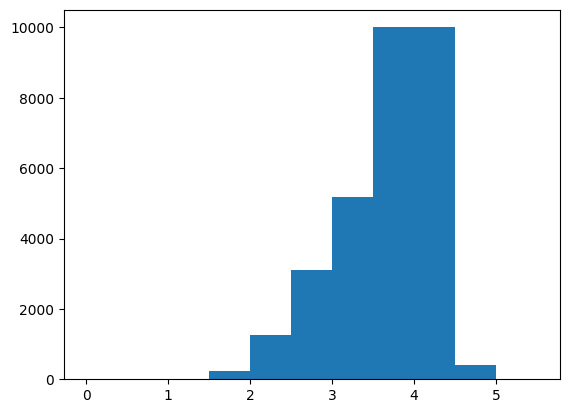

In [279]:
plt.hist(prediction.detach().numpy(),bins=[0,0.5,1,1.5,2,2.5,3,3.5,4.5,5,5.5])

In [21]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(model, 'recsys.pth', confirm=True)

In [23]:
# This cell loads your best model
if skip_training:
    model = RecommenderSystem(trainset.n_users, trainset.n_items)
    tools.load_model(model, 'recsys.pth', device)

Model loaded from recsys.pth.


The next cell tests the accuracy of your best model. It is enough to submit .pth files.

**IMPORTANT**:
* During testing, the predictions are produced by `predictions = model(user_ids, item_ids)` with the `user_ids` and `item_ids` loaded from `RatingsData`.
* There is a size limit of 30Mb for saved models. Please make sure that your model loads in the cell above.